In [1]:
import requests
import numpy as np
import pandas as pd
import statsmodels.api as sm


In [2]:
# Угол наклона цены 
def indSlope(series,n):
    
    array_sl = [j*0 for j in range(n-1)]
    
    for j in range(n,len(series)+1):
        y = series[j-n:j]
        x = np.array(range(n))
        x_sc = (x - x.min())/(x.max() - x.min())
        y_sc = (y - y.min())/(y.max() - y.min())
        x_sc = sm.add_constant(x_sc)
        model = sm.OLS(y_sc,x_sc)
        results = model.fit()
        array_sl.append(results.params.iloc[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(array_sl))))
    return np.array(slope_angle)

In [3]:
def indATR(source_DF,n):
    df = source_DF.copy()
    df['H-L']=abs(df['high']-df['low'])
    df['H-PC']=abs(df['high']-df['close'].shift(1))
    df['L-PC']=abs(df['low']-df['close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df_temp = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df_temp

In [4]:
# Добавляем новые данные

def PrepareDF(DF):
    ohlc = DF.iloc[:,[0,1,2,3,4,5]]
    ohlc.columns = ["date","open","high","low","close","volume"]
    ohlc=ohlc.set_index('date')
    df = indATR(ohlc,14).reset_index()
    df['slope'] = indSlope(df['close'],5)
    df['channel_max'] = df['high'].rolling(10).max()
    df['channel_min'] = df['low'].rolling(10).min()
    df['position_in_channel'] = (df['close']-df['channel_min']) / (df['channel_max']-df['channel_min'])
    df = df.set_index('date')
    df = df.reset_index()
    return(df)


In [5]:
# ишем локальный min / локальный max

def isLCC(DF,i):
    df=DF.copy()
    LCC=0
    
    if df['close'][i]<=df['close'][i+1] and df['close'][i]<=df['close'][i-1] and df['close'][i+1]>df['close'][i-1]:
        #найдено Дно
        LCC = i-1;
    return LCC

def isHCC(DF,i):
    df=DF.copy()
    HCC=0
    if df['close'][i]>=df['close'][i+1] and df['close'][i]>=df['close'][i-1] and df['close'][i+1]<df['close'][i-1]:
        #найдена вершина
        HCC = i;
    return HCC





In [7]:
def getMaxMinChannel(DF, n):
    maxx=0
    minn=DF['low'].max()
    for i in range (1,n):
        if maxx<DF['high'][len(DF)-i]:
            maxx=DF['high'][len(DF)-i]
        if minn>DF['low'][len(DF)-i]:
            minn=DF['low'][len(DF)-i]
    return(maxx,minn)

In [13]:
# Установите начальную и конечную даты для получения исторических данных

interval = '5m'  # интервал дней
symbol = 'ETHUSDT'
end_time = pd.Timestamp.now()  # текущее время
start_time = end_time - pd.Timedelta(days=2)  # 180 дней назад
start_time = int(start_time.timestamp() * 1000)  # перевод в миллисекунды
end_time = int(end_time.timestamp() * 1000)  # перевод в миллисекунды

# Загрузите данные

url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&startTime={start_time}&endTime={end_time}'
response = requests.get(url)
data = response.json()

# Преобразуйте данные в формат DataFrame

df = pd.DataFrame(data, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
                                 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
                                 'Taker buy quote asset volume', 'Ignore'])

# исключаем лишние столбцы, устанавливаем необходимые нам и меняем очередность выдачи (сначала более новые)
df = df[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
# Приводим столбци к нужному нам формату
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype (float)

In [14]:
# переворачиваем от болшего времени к позднему
df=df[::-1]


In [15]:
df

,timestamp,open,high,low,close,volume
499,2024-07-17 08:15:00,3473.52,3475.78,3463.41,3465.69,2422.4373
498,2024-07-17 08:10:00,3482.05,3483.00,3473.32,3473.51,1592.1356
497,2024-07-17 08:05:00,3489.44,3490.60,3479.37,3482.05,1332.8784
496,2024-07-17 08:00:00,3486.23,3489.43,3485.51,3489.43,755.1795
495,2024-07-17 07:55:00,3483.53,3488.40,3483.29,3486.22,648.9048
...,...,...,...,...,...,...
4,2024-07-15 15:00:00,3372.48,3393.69,3371.65,3381.92,4328.6692
3,2024-07-15 14:55:00,3369.23,3376.31,3368.34,3372.48,888.1959
2,2024-07-15 14:50:00,3370.53,3371.24,3367.00,3369.22,676.1974
1,2024-07-15 14:45:00,3366.19,3372.68,3364.91,3370.52,2345.3426


In [16]:
prepared_df=PrepareDF(df)

In [18]:
prepared_df

,date,open,high,low,close,volume,TR,ATR,slope,channel_max,channel_min,position_in_channel
0,2024-07-17 08:15:00,3473.52,3475.78,3463.41,3465.69,2422.4373,NaN,NaN,0.000000,NaN,NaN,NaN
1,2024-07-17 08:10:00,3482.05,3483.00,3473.32,3473.51,1592.1356,17.31,NaN,0.000000,NaN,NaN,NaN
2,2024-07-17 08:05:00,3489.44,3490.60,3479.37,3482.05,1332.8784,17.09,NaN,0.000000,NaN,NaN,NaN
3,2024-07-17 08:00:00,3486.23,3489.43,3485.51,3489.43,755.1795,7.38,NaN,0.000000,NaN,NaN,NaN
4,2024-07-17 07:55:00,3483.53,3488.40,3483.29,3486.22,648.9048,6.14,NaN,43.832870,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
495,2024-07-15 15:00:00,3372.48,3393.69,3371.65,3381.92,4328.6692,22.04,10.960000,44.548002,3393.69,3362.2,0.626231
496,2024-07-15 14:55:00,3369.23,3376.31,3368.34,3372.48,888.1959,13.58,11.030000,34.327645,3393.69,3362.2,0.326453
497,2024-07-15 14:50:00,3370.53,3371.24,3367.00,3369.22,676.1974,5.48,10.928571,-0.173384,3393.69,3362.2,0.222928
498,2024-07-15 14:45:00,3366.19,3372.68,3364.91,3370.52,2345.3426,7.77,11.102857,-37.314821,3393.69,3362.2,0.264211


<Axes: >

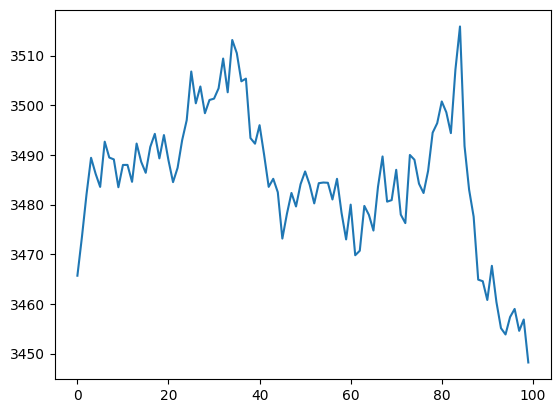

In [20]:
prepared_df[0:100]['close'].plot()

<Axes: >

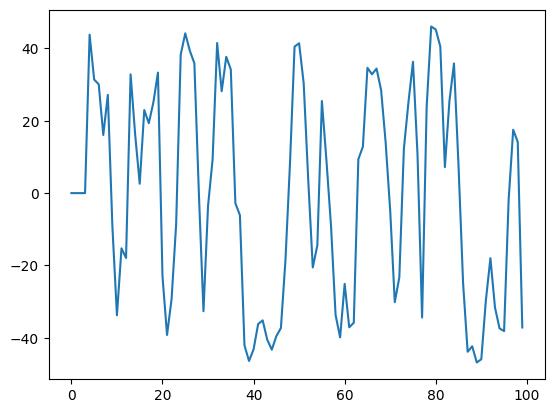

In [21]:
prepared_df[0:100]['slope'].plot()

In [ ]:
prepared_df[0:100][['channel_max','channel_min','close']].plot()

In [ ]:
prepared_df[0:100][['position_in_channel']].plot()